In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from pandas import concat, Series

from IPython.display import clear_output, display

## preprocess data for modeling

In [2]:
from preproc_functions import pre_process

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train['stmt_date'] = pd.to_datetime(train['stmt_date'])
# train['def_date_1'] = pd.to_datetime(train['def_date'], format="%d/%m/%Y")
train['def_date'] = pd.to_datetime(train['def_date'])
train.sort_values('stmt_date', inplace=True)

/var/folders/kj/yvh7dv5569ggqx7tcy8crpp00000gn/T/ipykernel_15962/2445187690.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train['def_date'] = pd.to_datetime(train['def_date'])


In [5]:
# train['def_date'].dropna()[train['def_date_1'].dropna()!=train['def_date_2'].dropna()][['def_date','def_date_1','def_date_2']]

#### Loading custom bins for ratio binning

In [6]:
with open('custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [7]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {},
    'category_pd': {}
}

In [8]:
complete_data , preproc_params = pre_process(train, 
                                           custom_bins=custom_bins, 
                                           preproc_params = preproc_params,  
                                           quantiles = 50,  # default bin#
                                           days_until_statement = 150 # for default value calc.
                                            )

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for roe_quantile
calc growth features
Custom bins for net_income_growth_quantile


/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/juanroalvarado/miniconda3/envs/horserace/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


# Select Featues for New and Recucrring firms model

In [9]:
### features for first firm
features = [
    # 'asst_tot_quantile_values', ####
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    # 'cash_assets_ratio_quantile_values', ####
    'dscr_quantile_values',
    'roe_quantile_values',
    'cfo_quantile_values',
    # 'ebitda',
    # 'ateco_sector_pd',
    # 'sector_group_pd', ####
    # 'legal_struct_pd',
    'regional_code_pd' ####
]

## train model

In [10]:
from xgboost import XGBClassifier

In [14]:
params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "eta": 0.1,
            "max_depth": 4,
            "min_child_weight": 1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0,
            "alpha": 0.1,
            "lambda": .1,
            "n_estimators":250
         }

model = XGBClassifier(**params)
        
fit_model = model.fit(X=complete_data[features], y=complete_data['default'])

## generate predictions for sanity check

In [16]:
comp_predictions = fit_model.predict_proba(complete_data[features])[:,1]

In [18]:
comp_results = complete_data[['default']].copy()
comp_results['predictions'] = comp_predictions

In [19]:
comp_results.shape

(1023552, 2)

ROC AUC 0.8409773797334936


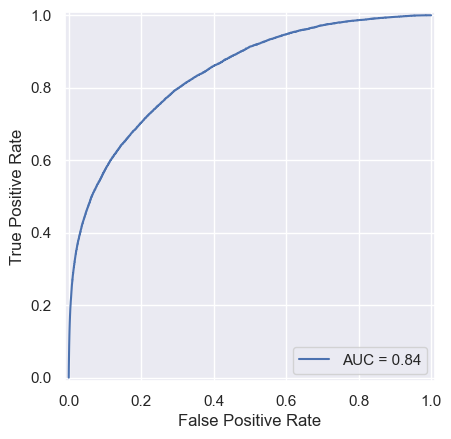

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(comp_results['default'], comp_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [22]:
import calibrator

## Calibrate predictions and look at rates

In [27]:
calibrated_preds = calibrator.calibrator(comp_results['predictions'])

In [28]:
 comp_results['default'].mean(), comp_results['predictions'].mean(), calibrated_preds.mean()

(np.float64(0.012640295754392546),
 np.float32(0.012642804),
 np.float32(0.02507962))

# Save data for estimation

In [29]:
custom_bins.keys()

dict_keys(['financial_leverage_quantile', 'profitability_ratio_quantile', 'net_income_growth_quantile', 'roe_quantile'])

In [30]:
for k in preproc_params.keys():
    print(k, preproc_params[k].keys())

quantile_bins dict_keys(['asst_tot_quantile', 'financial_leverage_quantile', 'profitability_ratio_quantile', 'roe_quantile', 'quick_ratio_v2_quantile', 'cash_assets_ratio_quantile', 'dscr_quantile', 'cfo_quantile', 'net_income_growth_quantile', 'sales_growth_quantile'])
quantile_values dict_keys(['asst_tot_quantile', 'financial_leverage_quantile', 'profitability_ratio_quantile', 'roe_quantile', 'quick_ratio_v2_quantile', 'cash_assets_ratio_quantile', 'dscr_quantile', 'cfo_quantile', 'net_income_growth_quantile', 'sales_growth_quantile'])
category_pd dict_keys(['ateco_sector_pd_values', 'sector_group_pd_values', 'regional_code_pd_values', 'legal_struct_pd_values'])


In [32]:
historical_growth.to_csv('historical_features.csv')

In [31]:
with open('custom_bins_v2.pkl', 'wb') as output:
    pickle.dump(custom_bins, output)

In [32]:
with open('preproc_params_v2.pkl', 'wb') as output:
    pickle.dump(preproc_params, output)

In [33]:
with open('trained_model_v2.pkl', 'wb') as output:
    pickle.dump(model, output)

# hyperparam tuning - commented out, was used during testing

In [94]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import roc_auc_score, make_scorer

In [95]:
# param_dist = {
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200, 300],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.5, 1],
#     'reg_alpha': [0, 0.1, 1, 10],
#     'reg_lambda': [1, 5, 10, 20]
# }
# # param_dist = {
# #         'subsample': 0.6,
# #      'reg_lambda': 10,
# #      'reg_alpha': 10,
# #      'n_estimators': 200,
# #      'min_child_weight': 5,
# #      'max_depth': 9,
# #      'learning_rate': 0.05,
# #      'gamma': 0.1,
# #      'colsample_bytree': 1.0}

# # Create the scorer
# scorer = make_scorer(roc_auc_score, needs_proba=True)

In [96]:
# rec_data_opt = train_data_proc[train_data_proc['is_first_occurrence']==0]

In [97]:
# model = XGBClassifier(n_estimators=100)

In [98]:
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,  # Number of parameter settings to sample
#     scoring=scorer,
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

In [99]:
# random_search.fit(rec_data_opt[rec_features], rec_data_opt['default'])

In [100]:
# results_df = pd.DataFrame(random_search.cv_results_)

# # Sort by the best score in descending order
# sorted_results = results_df.sort_values(by="mean_test_score", ascending=False)

# # Display the top 5 parameter combinations
# print("Top 3 Parameter Combinations:")
# print(sorted_results[['mean_test_score', 'params']].head())

In [101]:
# random_search.best_params_